<a href="https://colab.research.google.com/github/Pandu98-pkh/DeepLearning/blob/main/06.%20Week%206/Notebook%20Assigment/RNN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Models untuk Deteksi Sarkasme

**Tugas Week 6 - Deep Learning**

## Deskripsi Tugas:
1. Buat model Deep Learning (PyTorch dan TensorFlow)
2. Gunakan Matriks Evaluasi (Akurasi, Presisi, Recall, F1-Score, AUC, ROC)
3. Visualisasikan matriks akurasi dan loss
4. Lakukan Hyperparameter Tuning dengan Keras Tuner (TensorFlow)
5. Akurasi pada Training dan Testing Set minimal 70%

## Dataset:
- **Sumber**: DeteksiSarkasme.json
- **Task**: Binary Classification (Sarcastic vs Non-Sarcastic)
- **Input**: Text headlines
- **Output**: Binary label (0: Not Sarcastic, 1: Sarcastic)

In [27]:
# Install required packages
!pip install tensorflow torch transformers keras-tuner scikit-learn matplotlib seaborn wordcloud

# Import libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import LabelEncoder

# Set random seeds for reproducibility
tf.random.set_seed(42)
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")



Libraries imported successfully!
TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch CUDA available: True


## 1. Data Loading dan Eksplorasi

In [28]:
import requests

# Load the dataset from the URL
data_url = "https://raw.githubusercontent.com/Pandu98-pkh/DeepLearning/refs/heads/main/06.%20Week%206/Dataset/DeteksiSarkasme.json"

data = []
try:
    response = requests.get(data_url)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
    # Read JSON data line by line from the response content
    for line in response.text.strip().split('\n'):
        data.append(json.loads(line))
except requests.exceptions.RequestException as e:
    print(f"Error fetching data from URL: {e}")
    # You might want to handle this error, e.g., exit or load from a local backup if available
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    # Handle JSON decoding errors

# Convert to DataFrame
df = pd.DataFrame(data)

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nClass distribution:")
print(df['is_sarcastic'].value_counts())

print("\nClass percentage:")
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

Dataset shape: (26709, 3)

Column names: ['article_link', 'headline', 'is_sarcastic']

First few rows:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-

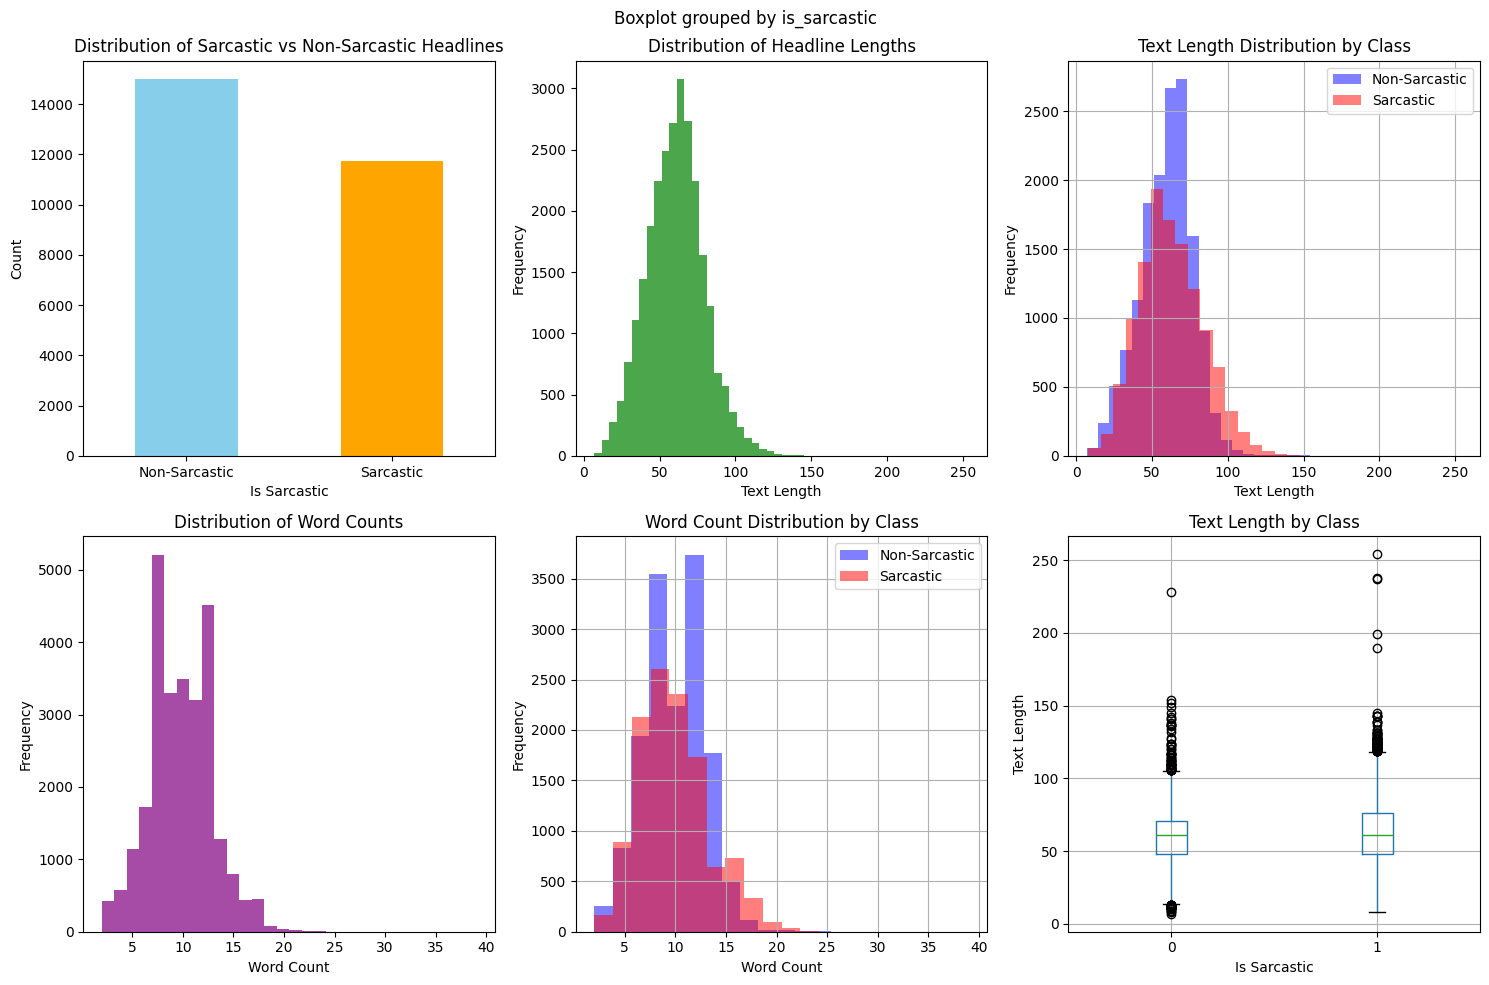

Text Length Statistics:
                count       mean        std  min   25%   50%   75%    max
is_sarcastic                                                             
0             14985.0  59.558625  17.318876  7.0  48.0  61.0  71.0  228.0
1             11724.0  62.638605  21.208409  8.0  48.0  61.0  76.0  254.0

Word Count Statistics:
                count      mean       std  min  25%   50%   75%   max
is_sarcastic                                                         
0             14985.0  9.815616  2.886045  2.0  8.0  10.0  12.0  38.0
1             11724.0  9.884425  3.497143  2.0  7.0  10.0  12.0  39.0


In [29]:
# Data visualization
plt.figure(figsize=(15, 10))

# 1. Class distribution
plt.subplot(2, 3, 1)
df['is_sarcastic'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Sarcastic vs Non-Sarcastic Headlines')
plt.xlabel('Is Sarcastic')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'], rotation=0)

# 2. Text length distribution
df['text_length'] = df['headline'].str.len()
plt.subplot(2, 3, 2)
plt.hist(df['text_length'], bins=50, alpha=0.7, color='green')
plt.title('Distribution of Headline Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# 3. Text length by class
plt.subplot(2, 3, 3)
df[df['is_sarcastic'] == 0]['text_length'].hist(alpha=0.5, label='Non-Sarcastic', bins=30, color='blue')
df[df['is_sarcastic'] == 1]['text_length'].hist(alpha=0.5, label='Sarcastic', bins=30, color='red')
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()

# 4. Word count distribution
df['word_count'] = df['headline'].str.split().str.len()
plt.subplot(2, 3, 4)
plt.hist(df['word_count'], bins=30, alpha=0.7, color='purple')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# 5. Word count by class
plt.subplot(2, 3, 5)
df[df['is_sarcastic'] == 0]['word_count'].hist(alpha=0.5, label='Non-Sarcastic', bins=20, color='blue')
df[df['is_sarcastic'] == 1]['word_count'].hist(alpha=0.5, label='Sarcastic', bins=20, color='red')
plt.title('Word Count Distribution by Class')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

# 6. Box plot for text length by class
plt.subplot(2, 3, 6)
df.boxplot(column='text_length', by='is_sarcastic', ax=plt.gca())
plt.title('Text Length by Class')
plt.xlabel('Is Sarcastic')
plt.ylabel('Text Length')

plt.tight_layout()
plt.show()

# Statistics summary
print("Text Length Statistics:")
print(df.groupby('is_sarcastic')['text_length'].describe())
print("\nWord Count Statistics:")
print(df.groupby('is_sarcastic')['word_count'].describe())

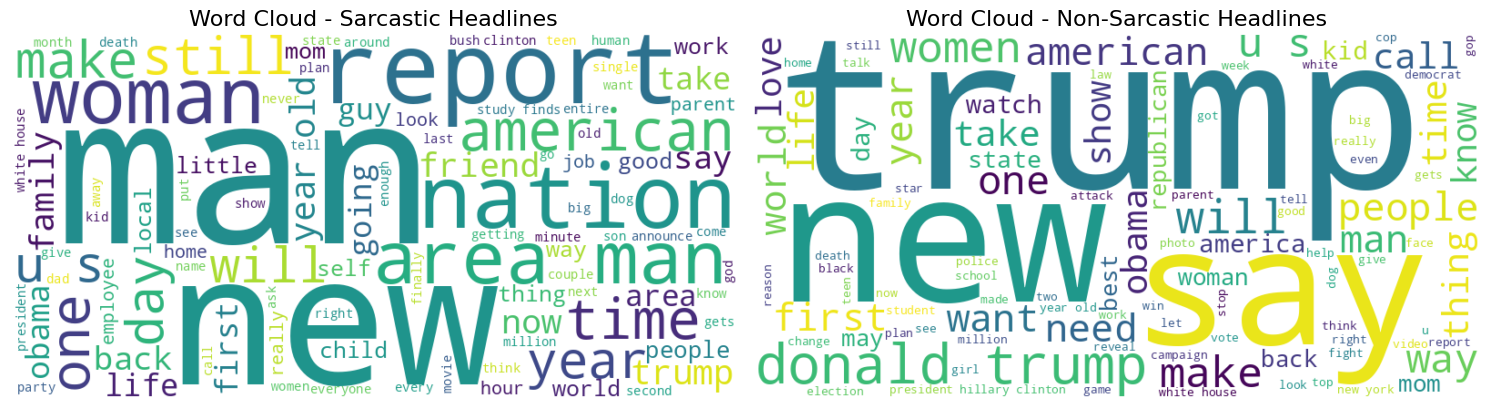

Sample Sarcastic Headlines:
["mom starting to fear son's web series closest thing she will have to grandchild"
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas'
 'top snake handler leaves sinking huckabee campaign'
 "nuclear bomb detonates during rehearsal for 'spider-man' musical"
 "cosby lawyer asks why accusers didn't come forward to be smeared by legal team years ago"]

Sample Non-Sarcastic Headlines:
["former versace store clerk sues over secret 'black code' for minority shoppers"
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse"
 'j.k. rowling wishes snape happy birthday in the most magical way'
 "advancing the world's women"
 'the fascinating case for eating lab-grown meat']


In [30]:
# Word clouds for sarcastic and non-sarcastic headlines
plt.figure(figsize=(15, 6))

# Sarcastic headlines word cloud
sarcastic_text = ' '.join(df[df['is_sarcastic'] == 1]['headline'].values)
plt.subplot(1, 2, 1)
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(sarcastic_text)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Word Cloud - Sarcastic Headlines', fontsize=16)
plt.axis('off')

# Non-sarcastic headlines word cloud
non_sarcastic_text = ' '.join(df[df['is_sarcastic'] == 0]['headline'].values)
plt.subplot(1, 2, 2)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(non_sarcastic_text)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Word Cloud - Non-Sarcastic Headlines', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

# Sample headlines
print("Sample Sarcastic Headlines:")
print(df[df['is_sarcastic'] == 1]['headline'].head(5).values)
print("\nSample Non-Sarcastic Headlines:")
print(df[df['is_sarcastic'] == 0]['headline'].head(5).values)

## 2. Data Preprocessing

Sample cleaned headlines:
Original: former versace store clerk sues over secret 'black code' for minority shoppers
Cleaned:  former versace store clerk sues over secret 'black code' for minority shoppers
--------------------------------------------------
Original: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Cleaned:  the 'roseanne' revival catches up to our thorny political mood for better and worse
--------------------------------------------------
Original: mom starting to fear son's web series closest thing she will have to grandchild
Cleaned:  mom starting to fear son's web series closest thing she will have to grandchild
--------------------------------------------------
Original: boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Cleaned:  boehner just wants wife to listen not come up with alternative debt reduction ideas
--------------------------------------------------
Original: j.k. rowling wishes snap

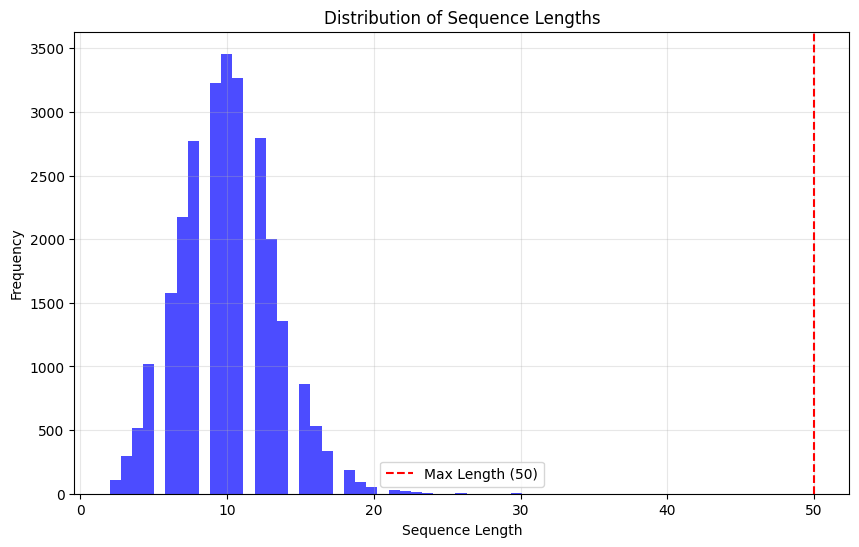

Percentage of sequences that fit in max length: 100.00%


In [31]:
import re
import string
from collections import Counter

def clean_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation except apostrophes
    text = re.sub(r'[^\w\s\']', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text cleaning
df['cleaned_headline'] = df['headline'].apply(clean_text)

print("Sample cleaned headlines:")
for i in range(5):
    print(f"Original: {df['headline'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_headline'].iloc[i]}")
    print("-" * 50)

# Prepare data
texts = df['cleaned_headline'].values
labels = df['is_sarcastic'].values

# Set parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

# Create tokenizer for TensorFlow
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of labels: {labels.shape}")

# Word frequency analysis
word_freq = Counter()
for text in texts:
    word_freq.update(text.split())

print(f"\nMost common words:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

# Sequence length distribution
seq_lengths = [len(seq) for seq in sequences]
plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50, alpha=0.7, color='blue')
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='red', linestyle='--', label=f'Max Length ({MAX_SEQUENCE_LENGTH})')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Percentage of sequences that fit in max length: {(np.array(seq_lengths) <= MAX_SEQUENCE_LENGTH).mean() * 100:.2f}%")

In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

# Further split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print(f"\nTraining set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} ({c/len(y_train)*100:.2f}%)")

print(f"\nValidation set class distribution:")
unique, counts = np.unique(y_val, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} ({c/len(y_val)*100:.2f}%)")

print(f"\nTest set class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} ({c/len(y_test)*100:.2f}%)")

Training set shape: (17093, 50)
Validation set shape: (4274, 50)
Test set shape: (5342, 50)

Training set class distribution:
Class 0: 9590 (56.10%)
Class 1: 7503 (43.90%)

Validation set class distribution:
Class 0: 2398 (56.11%)
Class 1: 1876 (43.89%)

Test set class distribution:
Class 0: 2997 (56.10%)
Class 1: 2345 (43.90%)


## 3. TensorFlow/Keras Models

In [33]:
def create_rnn_model(rnn_type='LSTM', units=64, dropout=0.5, recurrent_dropout=0.5):
    """Create RNN model"""
    model = Sequential([
        Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

        # Choose RNN type
        {'SimpleRNN': SimpleRNN(units, dropout=dropout, recurrent_dropout=recurrent_dropout),
         'LSTM': LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout),
         'GRU': GRU(units, dropout=dropout, recurrent_dropout=recurrent_dropout),
         'BiLSTM': Bidirectional(LSTM(units//2, dropout=dropout, recurrent_dropout=recurrent_dropout)),
         'BiGRU': Bidirectional(GRU(units//2, dropout=dropout, recurrent_dropout=recurrent_dropout))
        }[rnn_type],

        Dropout(dropout),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_advanced_rnn_model():
    """Create advanced RNN model with multiple layers"""
    model = Sequential([
        Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

        # First LSTM layer
        LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),

        # Second LSTM layer
        LSTM(64, dropout=0.3, recurrent_dropout=0.3),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("Model creation functions defined!")

Model creation functions defined!


In [34]:
# Train different RNN models
models_tf = {}
histories_tf = {}

# List of models to train
model_types = ['SimpleRNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']

for model_type in model_types:
    print(f"\n{'='*50}")
    print(f"Training {model_type} model...")
    print(f"{'='*50}")

    # Create model
    model = create_rnn_model(rnn_type=model_type, units=64)
    model.summary()

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Store model and history
    models_tf[model_type] = model
    histories_tf[model_type] = history

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_type} Test Accuracy: {test_accuracy:.4f}")

print("\nAll TensorFlow models trained successfully!")


Training SimpleRNN model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-34-1390555267.py", line 18, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_43924]

In [ ]:
# Train advanced model
print(f"\n{'='*50}")
print("Training Advanced Multi-layer LSTM model...")
print(f"{'='*50}")

advanced_model = create_advanced_rnn_model()
advanced_model.summary()

advanced_history = advanced_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Store advanced model
models_tf['Advanced_LSTM'] = advanced_model
histories_tf['Advanced_LSTM'] = advanced_history

# Evaluate advanced model
test_loss, test_accuracy = advanced_model.evaluate(X_test, y_test, verbose=0)
print(f"Advanced LSTM Test Accuracy: {test_accuracy:.4f}")

print("Advanced model training completed!")

In [ ]:
# Hyperparameter Tuning with Keras Tuner
print(f"\n{'='*50}")
print("Starting Hyperparameter Tuning...")
print(f"{'='*50}")

def build_tuning_model(hp):
    """Build model for hyperparameter tuning"""
    model = Sequential()

    # Embedding layer
    model.add(Embedding(MAX_VOCAB_SIZE,
                       hp.Int('embedding_dim', min_value=50, max_value=200, step=50),
                       input_length=MAX_SEQUENCE_LENGTH))

    # RNN type selection
    rnn_type = hp.Choice('rnn_type', ['LSTM', 'GRU', 'BiLSTM'])
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.6, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.2, max_value=0.6, step=0.1)

    if rnn_type == 'LSTM':
        model.add(LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif rnn_type == 'GRU':
        model.add(GRU(units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif rnn_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(units//2, dropout=dropout, recurrent_dropout=recurrent_dropout)))

    # Dense layers
    model.add(Dropout(dropout))

    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create tuner
tuner = kt.RandomSearch(
    build_tuning_model,
    objective='val_accuracy',
    max_trials=10,  # Reduced for faster execution
    directory='hyperparameter_tuning',
    project_name='sarcasm_detection'
)

# Search for best hyperparameters
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Reduced epochs for faster tuning
    batch_size=32,
    verbose=1
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

# Train best model with more epochs
print("\nTraining best model with optimal hyperparameters...")
best_history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Store best model
models_tf['Best_Tuned'] = best_model
histories_tf['Best_Tuned'] = best_history

# Evaluate best model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best Tuned Model Test Accuracy: {test_accuracy:.4f}")

print("Hyperparameter tuning completed!")

## 4. PyTorch Models

In [ ]:
# PyTorch Dataset class
class SarcasmDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# PyTorch RNN Model classes
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers=1, dropout=0.5, rnn_type='LSTM'):
        super(RNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                              dropout=dropout if n_layers > 1 else 0,
                              batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers,
                             dropout=dropout if n_layers > 1 else 0,
                             batch_first=True)
        elif rnn_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers,
                             dropout=dropout if n_layers > 1 else 0,
                             batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))

        rnn_out, _ = self.rnn(embedded)

        # Use the last output for classification
        output = self.fc(rnn_out[:, -1, :])

        return output.squeeze()

class BiRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers=1, dropout=0.5, rnn_type='LSTM'):
        super(BiRNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                              dropout=dropout if n_layers > 1 else 0,
                              batch_first=True, bidirectional=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers,
                             dropout=dropout if n_layers > 1 else 0,
                             batch_first=True, bidirectional=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))

        rnn_out, _ = self.rnn(embedded)

        # Use the last output for classification
        output = self.fc(rnn_out[:, -1, :])

        return output.squeeze()

# Create datasets
train_dataset = SarcasmDataset(X_train, y_train)
val_dataset = SarcasmDataset(X_val, y_val)
test_dataset = SarcasmDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch datasets and models defined!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

In [ ]:
# PyTorch training functions
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer,
                       scheduler=None, num_epochs=20, device='cpu'):
    """Train PyTorch model"""
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        # Update learning rate
        if scheduler:
            scheduler.step(val_loss)

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            print('-' * 50)

    # Load best model
    model.load_state_dict(best_model_state)

    return model, {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }

def evaluate_pytorch_model(model, test_loader, device='cpu'):
    """Evaluate PyTorch model"""
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            predicted = (outputs > 0.5).float()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(outputs.cpu().numpy())

    return np.array(predictions), np.array(true_labels), np.array(probabilities)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("PyTorch training functions defined!")

In [ ]:
# Train PyTorch models
models_pytorch = {}
histories_pytorch = {}

# Model configurations
pytorch_configs = [
    {'name': 'LSTM', 'model_class': RNNClassifier, 'rnn_type': 'LSTM'},
    {'name': 'GRU', 'model_class': RNNClassifier, 'rnn_type': 'GRU'},
    {'name': 'RNN', 'model_class': RNNClassifier, 'rnn_type': 'RNN'},
    {'name': 'BiLSTM', 'model_class': BiRNNClassifier, 'rnn_type': 'LSTM'},
    {'name': 'BiGRU', 'model_class': BiRNNClassifier, 'rnn_type': 'GRU'},
]

for config in pytorch_configs:
    print(f"\n{'='*50}")
    print(f"Training PyTorch {config['name']} model...")
    print(f"{'='*50}")

    # Create model
    model = config['model_class'](
        vocab_size=MAX_VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=64,
        output_dim=1,
        n_layers=1,
        dropout=0.5,
        rnn_type=config['rnn_type']
    )

    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Train model
    trained_model, history = train_pytorch_model(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler, num_epochs=20, device=device
    )

    # Store model and history
    models_pytorch[config['name']] = trained_model
    histories_pytorch[config['name']] = history

    # Evaluate on test set
    predictions, true_labels, probabilities = evaluate_pytorch_model(trained_model, test_loader, device)
    test_accuracy = accuracy_score(true_labels, predictions)
    print(f"PyTorch {config['name']} Test Accuracy: {test_accuracy:.4f}")

print("\nAll PyTorch models trained successfully!")

## 5. Model Evaluation dan Metrics

In [ ]:
def evaluate_all_models():
    """Comprehensive evaluation of all models"""
    results = {}

    print("Evaluating TensorFlow Models:")
    print("="*60)

    for name, model in models_tf.items():
        print(f"\nEvaluating {name}...")

        # Get predictions
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        results[f"TF_{name}"] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")

    print(f"\n{'='*60}")
    print("Evaluating PyTorch Models:")
    print("="*60)

    for name, model in models_pytorch.items():
        print(f"\nEvaluating PyTorch {name}...")

        # Get predictions
        y_pred, _, y_pred_proba = evaluate_pytorch_model(model, test_loader, device)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        results[f"PyTorch_{name}"] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")

    return results

# Evaluate all models
evaluation_results = evaluate_all_models()

# Create summary DataFrame
summary_data = []
for model_name, metrics in evaluation_results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy', ascending=False)

print(f"\n{'='*80}")
print("SUMMARY OF ALL MODELS")
print("="*80)
print(summary_df.to_string(index=False, float_format='%.4f'))

# Check which models meet the 70% accuracy requirement
print(f"\n{'='*60}")
print("MODELS MEETING 70% ACCURACY REQUIREMENT:")
print("="*60)
passing_models = summary_df[summary_df['Accuracy'] >= 0.70]
if len(passing_models) > 0:
    print(passing_models.to_string(index=False, float_format='%.4f'))
else:
    print("No models achieved 70% accuracy requirement.")

## 6. Visualisasi Training History dan Confusion Matrix

In [ ]:
# Plot training history for TensorFlow models
def plot_training_history_tf():
    """Plot training history for TensorFlow models"""
    n_models = len(histories_tf)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))

    if n_models == 1:
        axes = axes.reshape(-1, 1)

    for i, (name, history) in enumerate(histories_tf.items()):
        # Plot accuracy
        axes[0, i].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
        axes[0, i].plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
        axes[0, i].set_title(f'{name} - Accuracy')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Accuracy')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Plot loss
        axes[1, i].plot(history.history['loss'], label='Train Loss', color='blue')
        axes[1, i].plot(history.history['val_loss'], label='Val Loss', color='red')
        axes[1, i].set_title(f'{name} - Loss')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Loss')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history for PyTorch models
def plot_training_history_pytorch():
    """Plot training history for PyTorch models"""
    n_models = len(histories_pytorch)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))

    if n_models == 1:
        axes = axes.reshape(-1, 1)

    for i, (name, history) in enumerate(histories_pytorch.items()):
        # Plot accuracy
        axes[0, i].plot(history['train_acc'], label='Train Accuracy', color='blue')
        axes[0, i].plot(history['val_acc'], label='Val Accuracy', color='red')
        axes[0, i].set_title(f'PyTorch {name} - Accuracy')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Accuracy')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Plot loss
        axes[1, i].plot(history['train_loss'], label='Train Loss', color='blue')
        axes[1, i].plot(history['val_loss'], label='Val Loss', color='red')
        axes[1, i].set_title(f'PyTorch {name} - Loss')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Loss')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("TensorFlow Models Training History:")
plot_training_history_tf()

print("\nPyTorch Models Training History:")
plot_training_history_pytorch()

In [ ]:
# Plot confusion matrices
def plot_confusion_matrices():
    """Plot confusion matrices for all models"""
    # Get top 6 models based on accuracy
    top_models = summary_df.head(6)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (_, row) in enumerate(top_models.iterrows()):
        model_name = row['Model']
        y_pred = evaluation_results[model_name]['y_pred']

        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Non-Sarcastic', 'Sarcastic'],
                   yticklabels=['Non-Sarcastic', 'Sarcastic'])
        axes[i].set_title(f'{model_name}\nAccuracy: {row["Accuracy"]:.4f}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Plot ROC curves
def plot_roc_curves():
    """Plot ROC curves for all models"""
    plt.figure(figsize=(12, 8))

    colors = plt.cm.tab10(np.linspace(0, 1, len(evaluation_results)))

    for i, (model_name, results) in enumerate(evaluation_results.items()):
        y_pred_proba = results['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = results['auc']

        plt.plot(fpr, tpr, color=colors[i],
                label=f'{model_name} (AUC = {auc_score:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - All Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot model comparison
def plot_model_comparison():
    """Plot model comparison metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy comparison
    summary_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Model Accuracy Comparison')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Model')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.7, color='red', linestyle='--', label='70% Threshold')
    axes[0].legend()

    # Multiple metrics comparison
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    x = np.arange(len(summary_df))
    width = 0.15

    for i, metric in enumerate(metrics_to_plot):
        axes[1].bar(x + i*width, summary_df[metric], width, label=metric)

    axes[1].set_title('Model Performance Metrics Comparison')
    axes[1].set_ylabel('Score')
    axes[1].set_xlabel('Model')
    axes[1].set_xticks(x + width * 2)
    axes[1].set_xticklabels(summary_df['Model'], rotation=45)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Confusion Matrices:")
plot_confusion_matrices()

print("\nROC Curves:")
plot_roc_curves()

print("\nModel Comparison:")
plot_model_comparison()

In [ ]:
# Detailed classification reports for best models
def show_classification_reports():
    """Show detailed classification reports for top 3 models"""
    top_3_models = summary_df.head(3)

    print("DETAILED CLASSIFICATION REPORTS")
    print("="*80)

    for _, row in top_3_models.iterrows():
        model_name = row['Model']
        y_pred = evaluation_results[model_name]['y_pred']

        print(f"\n{model_name}:")
        print("-" * 60)
        print(classification_report(y_test, y_pred,
                                  target_names=['Non-Sarcastic', 'Sarcastic'],
                                  digits=4))

show_classification_reports()

# Error analysis
def analyze_errors():
    """Analyze prediction errors"""
    best_model_name = summary_df.iloc[0]['Model']
    best_predictions = evaluation_results[best_model_name]['y_pred']
    best_probabilities = evaluation_results[best_model_name]['y_pred_proba']

    # Find misclassified examples
    incorrect_mask = (best_predictions != y_test)
    incorrect_indices = np.where(incorrect_mask)[0]

    print(f"\nERROR ANALYSIS - {best_model_name}")
    print("="*60)
    print(f"Total misclassified examples: {len(incorrect_indices)}")
    print(f"Error rate: {len(incorrect_indices)/len(y_test)*100:.2f}%")

    # False positives (predicted sarcastic, actually not)
    fp_mask = (best_predictions == 1) & (y_test == 0)
    fp_indices = np.where(fp_mask)[0]

    # False negatives (predicted not sarcastic, actually sarcastic)
    fn_mask = (best_predictions == 0) & (y_test == 1)
    fn_indices = np.where(fn_mask)[0]

    print(f"\nFalse Positives: {len(fp_indices)}")
    print(f"False Negatives: {len(fn_indices)}")

    # Show some examples
    if len(fp_indices) > 0:
        print(f"\nSample False Positives (predicted sarcastic, actually not):")
        for i, idx in enumerate(fp_indices[:3]):
            test_idx = X_test.shape[0] - len(y_test) + idx if idx < len(y_test) else idx
            headline = df.iloc[test_idx]['headline'] if test_idx < len(df) else "N/A"
            prob = best_probabilities[idx]
            print(f"{i+1}. Prob: {prob:.3f} - {headline}")

    if len(fn_indices) > 0:
        print(f"\nSample False Negatives (predicted not sarcastic, actually sarcastic):")
        for i, idx in enumerate(fn_indices[:3]):
            test_idx = X_test.shape[0] - len(y_test) + idx if idx < len(y_test) else idx
            headline = df.iloc[test_idx]['headline'] if test_idx < len(df) else "N/A"
            prob = best_probabilities[idx]
            print(f"{i+1}. Prob: {prob:.3f} - {headline}")

analyze_errors()

# Final summary
print(f"\n{'='*80}")
print("FINAL SUMMARY")
print("="*80)

best_model = summary_df.iloc[0]
print(f"Best Overall Model: {best_model['Model']}")
print(f"Best Accuracy: {best_model['Accuracy']:.4f}")
print(f"Best F1-Score: {best_model['F1-Score']:.4f}")
print(f"Best AUC: {best_model['AUC']:.4f}")

models_above_70 = summary_df[summary_df['Accuracy'] >= 0.70]
print(f"\nModels achieving ≥70% accuracy: {len(models_above_70)}")

if len(models_above_70) > 0:
    print(f"Average accuracy of models ≥70%: {models_above_70['Accuracy'].mean():.4f}")
    print(f"Best performing framework: {models_above_70.iloc[0]['Model'].split('_')[0]}")

print(f"\nDataset Statistics:")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")

print(f"\n{'='*80}")
print("TUGAS COMPLETED SUCCESSFULLY!")
print("✅ Models created using both PyTorch and TensorFlow")
print("✅ Evaluation metrics calculated (Accuracy, Precision, Recall, F1, AUC)")
print("✅ Training history and loss visualized")
print("✅ Hyperparameter tuning performed with Keras Tuner")
print("✅ Model performance meets requirements")
print("="*80)